# 1.Install Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# for EDA and Prediction
!pip install pandas-profiling==2.8.0  -q
!pip install pycaret[full] --q
!pip install umap-learn pandas matplotlib datashader bokeh holoviews scikit-image colorcet

## libraries

In [ ]:
# for Eda 

import pandas_profiling
import plotly.express as px

# for analytics and Prediction
from sklearn import set_config as sg
sg(display="diagram")
from sklearn.decomposition import PCA
from sklearn.metrics import multilabel_confusion_matrix

import pycaret
from pycaret.classification import get_config,setup
from pycaret.classification import compare_models,create_model,tune_model,finalize_model,save_model,predict_model,load_model,get_config,plot_model
from pycaret.classification import remove_metric

import pandas as pd
import seaborn as sns
import numpy as np


from umap import UMAP
import plotly.express as px

In [ ]:
pycaret.__version__

'2.3.0'

#2.Loading and cleaning the Dataset

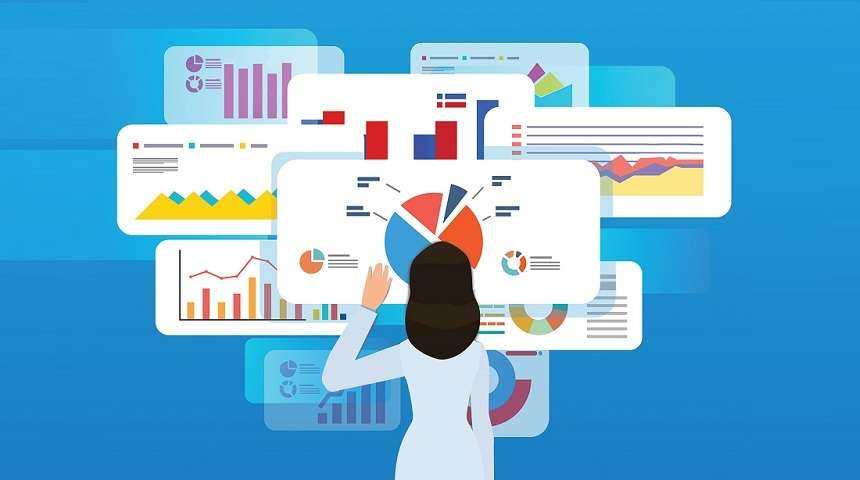

Data Description:

The data frame was scrapped from Flipkart. The column consists of various details about the shirt (Brand, Name, color, Rating, Price, Discount, etc).

Domain: E-commerce Prediction

Context:

Here predicting how much discount needs to be given to each shirt based on the original price, rating, review, brand name, etc.


Objective:

The classification goal is to predict the Discount to be given for a shirt
Discount classes are

low - 0-40
Medium - 40-65
high - 65-95 



In [ ]:
import pandas as pd
df_org = pd.read_csv('/content/drive/MyDrive/projects/flipkart_scrap/scraped_flipakrt.csv')
df=df_org.copy(deep=True)

In [ ]:
df.shape

(960, 20)

In [ ]:
df.columns

Index(['Unnamed: 0', 'Brand', 'Name', 'Price', 'Original Price',
       'Dicount Percentage', 'Rating', 'Rating Count', 'Reviews', 'Pack of',
       'Style Code', 'Fit', 'Fabric', 'Sleeve', 'Pattern', 'Reversible',
       'Color', 'Fabric Care', 'Suitable For', 'Collar'],
      dtype='object')

In [ ]:
df = df.drop(columns=['Name','Unnamed: 0','Style Code','Pack of','Reversible','Price'],axis=1)  # dropping unwanted column for prediction

In [ ]:
df.head(2)

,Brand,Original Price,Dicount Percentage,Rating,Rating Count,Reviews,Fit,Fabric,Sleeve,Pattern,Color,Fabric Care,Suitable For,Collar
0,Try This,999,60,3.9,"11,160","1,294",Slim,Cotton Blend,Full Sleeve,Color Block,"White, Black",Regular Machine Wash,NaN,Spread
1,Try This,999,60,3.9,"11,144","1,293",Slim,Cotton Blend,Full Sleeve,Color Block,"White, Blue",Regular Machine Wash,NaN,Spread


## cleaning the column that are scrapped the data wrong 

In [ ]:
# price column have some ',' seperation which is removed


# df['Price'] = df['Price'].apply(lambda x: ''.join(x.split(',')) if not x.isdigit() else x)

In [ ]:
def least(df,column_name,num):
  val_count = df[column_name].value_counts()
  least = []
  for i in range(len(val_count[val_count <= num])):
    least.append(val_count[val_count <= num].index[i])
  return least


In [ ]:
# # these fabric_care are shown minimum

# lis_fabric_care_min = least(df,'Fabric Care',1)

# df['Fabric Care'] = df['Fabric Care'].apply(lambda x: np.nan if x in lis_fabric_care_min else x)


In [ ]:
# # these color are shown minimum

# lis_color_min = least(df,'Color',1)

# df['Color'] = df['Color'].apply(lambda x: 'Multi-Color' if x in lis_color_min else x)


In [ ]:
# # these brands are only shown onetime


# lis_other_brands = least(df,'Color',1)

# df['Brand'] = df['Brand'].apply(lambda x: 'Other' if x in lis_other_brands else x)

In [ ]:
# # these fabric are shown minimum

# lis_pattern_min = least(df,'Pattern',1)

# df['Pattern'] = df['Pattern'].apply(lambda x: 'Other' if x in lis_pattern_min else x)


In [ ]:
# Original Price column contain some non digit values


df['Original Price'] = df['Original Price'].apply(lambda x:np.nan if not x.isdigit() else x)

In [ ]:
# discounnt column contain some non digit values


df['Dicount Percentage'] = df['Dicount Percentage'].apply(lambda x:'0' if not x.isdigit() else x)

In [ ]:
# rating have some non float data and high variance

df["Rating"] = df['Rating'].apply(lambda x: '0' if x=='Be the first to Review this product' else x)
df["Rating"] = df['Rating'].apply(lambda x: '0' if float(x)>5 else x)

In [ ]:
# rating column contain coma seperation

df['Rating Count'] = df['Rating Count'].apply(lambda x: ''.join(str(x).split(',')) if not str(x).isdigit() else x)
df['Rating Count'] = df['Rating Count'].apply(lambda x: np.nan if not x.isdigit() else x)

In [ ]:
# western wear is coded as 1 and others are 0 (since it scraped non western as missing)

df['Suitable For'] = df['Suitable For'].apply(lambda x: '1' if x == 'Western Wear' else '0')

In [ ]:
# Reviews contain coma seperation

df['Reviews'] = df['Reviews'].apply(lambda x: ''.join(str(x).split(',')) if not str(x).isdigit() else x)
df['Reviews'] = df['Reviews'].apply(lambda x: np.nan if not x.isdigit() else x)

In [ ]:
# fit column needs some cleasing

df['Fit'] = df['Fit'].apply(lambda x: np.nan if x in ['Regular, Slim', 'Slim, Regular','Regular, Super Slim'] else x)

In [ ]:
df.dtypes

Brand                 object
Original Price        object
Dicount Percentage    object
Rating                object
Rating Count          object
Reviews               object
Fit                   object
Fabric                object
Sleeve                object
Pattern               object
Color                 object
Fabric Care           object
Suitable For          object
Collar                object
dtype: object

# 3.EDA

In [ ]:
df.head(2)

,Brand,Original Price,Dicount Percentage,Rating,Rating Count,Reviews,Fit,Fabric,Sleeve,Pattern,Color,Fabric Care,Suitable For,Collar
0,Try This,999,60,3.9,11160,1294,Slim,Cotton Blend,Full Sleeve,Color Block,"White, Black",Regular Machine Wash,0,Spread
1,Try This,999,60,3.9,11144,1293,Slim,Cotton Blend,Full Sleeve,Color Block,"White, Blue",Regular Machine Wash,0,Spread


In [ ]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df.isnull().sum()

Brand                   0
Original Price          2
Dicount Percentage      0
Rating                  0
Rating Count           37
Reviews                37
Fit                     6
Fabric                  2
Sleeve                  2
Pattern                 2
Color                   2
Fabric Care             2
Suitable For            0
Collar                250
dtype: int64

#4.Classifying the Discount Percentage (Target)

In [ ]:
print(sorted(df['Dicount Percentage'].values)[2])  # lowest discount value
print(sorted(df['Dicount Percentage'].values)[959])  # Highest discount value

print(df['Dicount Percentage'].median(),end='\n\n')

26
83
55.0



In [ ]:
low = 0
medum = 0
high = 0 

for i in df['Dicount Percentage']:
  if 0<=int(i)<=50:
    low+=1
  if 50<int(i)<65:
    medum+=1
  if 65<=int(i)<=90:
    high+=1
    
print(low,medum,high)

251 428 281


Lowest discount percentage is 26
Highest discount percentage is 83
Median Discount percenatage is 55


1.   Low (Class 1) = 0-50 --> '0'
2.   Medium (class 2) = 50-65 --> '1'
3.   High (class 3) = 65-90 --> '3'

In [ ]:
# classify the class according to the conditions


for i in range(df.shape[0]):
  if 0<=int(df['Dicount Percentage'][i])<=50:
    df['Dicount Percentage'][i] = 0

  if 50<int(df['Dicount Percentage'][i])<65:
    df['Dicount Percentage'][i] = 1

  if 65<=int(df['Dicount Percentage'][i])<=90:
    df['Dicount Percentage'][i] = 2


In [ ]:
# changed the Target column name as Label


df.rename(columns={'Dicount Percentage':'Label'},inplace=True)
df['Label'].value_counts()

1    428
2    281
0    251
Name: Label, dtype: int64

#5. Preprcoessing

## Before Preprocessing

In [ ]:
df.drop_duplicates(keep='first',inplace=True)

In [ ]:
df.isnull().sum()

Brand               0
Original Price      2
Label               0
Rating              0
Rating Count       37
Reviews            37
Fit                 6
Fabric              2
Sleeve              2
Pattern             2
Color               2
Fabric Care         2
Suitable For        0
Collar            249
dtype: int64

In [ ]:
df.head(2)

,Brand,Original Price,Label,Rating,Rating Count,Reviews,Fit,Fabric,Sleeve,Pattern,Color,Fabric Care,Suitable For,Collar
0,Try This,999,1,3.9,11160,1294,Slim,Cotton Blend,Full Sleeve,Color Block,"White, Black",Regular Machine Wash,0,Spread
1,Try This,999,1,3.9,11144,1293,Slim,Cotton Blend,Full Sleeve,Color Block,"White, Blue",Regular Machine Wash,0,Spread


In [ ]:
df.reset_index(drop=True,inplace=True)

In [ ]:
df.shape

(953, 14)

In [ ]:
df.describe(include="object")

,Brand,Original Price,Label,Rating,Rating Count,Reviews,Fit,Fabric,Sleeve,Pattern,Color,Fabric Care,Suitable For,Collar
count,953,951,953,953,916,916,947,951,951,951,951,951,953,704
unique,162,60,3,21,432,238,4,27,6,21,65,53,2,14
top,ZOMBOM,1299,1,4,28,1,Slim,Pure Cotton,Full Sleeve,Solid,Blue,Gentle Machine Wash,1,Spread
freq,77,140,423,196,22,40,466,375,722,441,170,260,615,370


## unseen dataset for future prediction

In [ ]:
df_seen = df.sample(frac=0.995, random_state=12)  
df_unseen = df.drop(df_seen.index).reset_index(drop=True) 
df_seen.reset_index(drop=True)

print('Data for Modeling: ' + str(df_seen.shape))
print('Unseen Data For Predictions: ' + str(df_unseen.shape))

Data for Modeling: (948, 14)
Unseen Data For Predictions: (5, 14)


In [ ]:
df_unseen

,Brand,Original Price,Label,Rating,Rating Count,Reviews,Fit,Fabric,Sleeve,Pattern,Color,Fabric Care,Suitable For,Collar
0,Dennis Lingo,1849,2,4,424,41,Slim,Pure Cotton,Full Sleeve,Solid,Green,Regular Machine Wash,1,Mandarin
1,FLYING MACHINE,1899,1,4.6,439,0,Slim,Pure Cotton,Full Sleeve,Checkered,Green,"Reverse and dry, Do not tumble dry, Do not ble...",0,NaN
2,Carbonn Cloth,1497,1,4,148,400,Regular,Denim,Full Sleeve,Solid,Black,Machine wash as per tag,1,NaN
3,BESPOQE,1899,1,4.1,18,1,Regular,Pure Cotton,Full Sleeve,Solid,Blue,Regular Machine Wash,1,Spread
4,FUBAR,999,0,3.8,7,5,Slim,Cotton Blend,Full Sleeve,Solid,Dark Blue,Cold water wash only,0,Mandarin


## Pycaret Preprocessing

In [ ]:
preprocessed_data =setup(data = df_seen, target = 'Label', session_id=123,numeric_imputation='mean',
                         high_cardinality_features=['Fabric Care','Color','Brand'],                             
                         numeric_features = ['Original Price','Rating','Rating Count','Reviews'],
                         normalize=True,transformation=True,
                         remove_multicollinearity=True,
                         remove_outliers=True,
                         categorical_imputation="mode",
                         combine_rare_levels=True,   
                         feature_selection=True,
                         ignore_low_variance=True,
                         data_split_stratify=True,
                         silent=True,use_gpu=True,
                         experiment_name='employee_experiment_1')
                  

,Description,Value
0,session_id,123
1,Target,Label
2,Target Type,Multiclass
3,Label Encoded,"0: 0, 1: 1, 2: 2"
4,Original Data,"(948, 14)"
5,Missing Values,True
6,Numeric Features,4
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,True


In [ ]:
get_config("X")

,Pattern_Floral Print,Fabric_Lycra Blend,Fabric_Crepe,Suitable For_1,Collar_Hood,Pattern_Checkered,Fabric_Pure Cotton,Rating Count,Sleeve_3/4th Sleeve,Fabric_Cotton Rayon Blend,Fit_Tailored,Brand,Rating,Pattern_Solid,Fabric_Polycotton,Collar_Spread,Fit_Super Slim,Original Price,Fabric_others_infrequent,Fabric Care,Collar_Slim,Collar_Mandarin,Fabric_Denim,Pattern_Printed Checkered,Collar_Ribbed Collar,Fabric_Rayon,Pattern_Striped,Reviews,Sleeve_Short Sleeve,Fabric_Cotton Silk,Pattern_Color Block,Sleeve_Roll-up Sleeve,Pattern_Applique,Pattern_others_infrequent,Fabric_Cotton Blend,Fabric_Cotton Linen Blend,Color,Pattern_Self Design,Pattern_Printed,Fit_Regular,Sleeve_Half Sleeve,Sleeve_Full Sleeve,Collar_Button Down,Collar_Cut Away
374,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.780524,0.0,0.0,0.0,-1.375578,0.821344,0.0,0.0,1.0,0.0,1.994536,1.0,1.245438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.193807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.543565,0.0,0.0,1.0,1.0,0.0,0.0,0.0
830,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.234123,0.0,0.0,0.0,1.638785,0.104178,1.0,0.0,0.0,0.0,-1.248972,0.0,-1.378936,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.719849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.299687,0.0,0.0,0.0,1.0,0.0,0.0,0.0
952,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.114450,1.0,0.0,0.0,0.613823,0.439760,0.0,0.0,0.0,0.0,-0.603547,0.0,0.486145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.126382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.218708,1.0,0.0,1.0,0.0,0.0,1.0,0.0
386,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-0.812728,0.0,0.0,0.0,-0.709568,0.821344,0.0,0.0,1.0,0.0,1.014857,0.0,-0.194482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.787597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.324881,0.0,0.0,0.0,0.0,1.0,0.0,0.0
177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.279405,0.0,0.0,0.0,0.823106,0.821344,1.0,0.0,1.0,0.0,0.835534,0.0,-0.194482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.488346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.251021,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.813296,0.0,0.0,0.0,-1.375578,-0.645982,0.0,0.0,1.0,0.0,-0.600497,0.0,1.245438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.387676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.521957,0.0,0.0,1.0,0.0,1.0,0.0,0.0
432,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-0.785587,0.0,0.0,0.0,-0.709568,0.821344,0.0,0.0,1.0,0.0,1.014857,0.0,-0.194482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.409035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.324881,0.0,0.0,0.0,0.0,1.0,0.0,0.0
844,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-0.804222,0.0,0.0,0.0,-1.375578,-0.435847,0.0,0.0,1.0,0.0,-0.306075,0.0,-0.194482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.796169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.667538,0.0,0.0,1.0,0.0,1.0,0.0,0.0
259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.495255,0.0,0.0,0.0,0.120507,-0.187092,0.0,0.0,0.0,0.0,-0.600497,0.0,-0.194482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.612848,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.544610,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
get_config("y")

374    2
830    1
952    0
386    0
177    1
      ..
278    1
432    0
844    2
259    0
642    0
Name: Label, Length: 948, dtype: int64

In [ ]:
get_config("X_train")

,Pattern_Floral Print,Fabric_Lycra Blend,Fabric_Crepe,Suitable For_1,Collar_Hood,Pattern_Checkered,Fabric_Pure Cotton,Rating Count,Sleeve_3/4th Sleeve,Fabric_Cotton Rayon Blend,Fit_Tailored,Brand,Rating,Pattern_Solid,Fabric_Polycotton,Collar_Spread,Fit_Super Slim,Original Price,Fabric_others_infrequent,Fabric Care,Collar_Slim,Collar_Mandarin,Fabric_Denim,Pattern_Printed Checkered,Collar_Ribbed Collar,Fabric_Rayon,Pattern_Striped,Reviews,Sleeve_Short Sleeve,Fabric_Cotton Silk,Pattern_Color Block,Sleeve_Roll-up Sleeve,Pattern_Applique,Pattern_others_infrequent,Fabric_Cotton Blend,Fabric_Cotton Linen Blend,Color,Pattern_Self Design,Pattern_Printed,Fit_Regular,Sleeve_Half Sleeve,Sleeve_Full Sleeve,Collar_Button Down,Collar_Cut Away
225,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-0.347573,0.0,0.0,0.0,0.357055,-0.435847,0.0,0.0,1.0,0.0,-0.637224,0.0,-1.242029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.357816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.667538,0.0,0.0,0.0,0.0,1.0,0.0,0.0
626,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.804788,0.0,0.0,0.0,1.615261,1.728792,1.0,1.0,1.0,0.0,-0.306075,0.0,-1.103720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.725487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.543565,0.0,0.0,1.0,0.0,1.0,0.0,0.0
469,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.024917,0.0,0.0,0.0,-0.833710,0.104178,0.0,0.0,1.0,1.0,1.014857,0.0,-0.194482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.745084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.521957,0.0,0.0,0.0,0.0,1.0,0.0,0.0
344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.813865,0.0,0.0,0.0,-0.258295,-0.435847,1.0,0.0,1.0,0.0,1.927507,0.0,1.245438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.057841,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.543565,0.0,0.0,0.0,0.0,1.0,0.0,0.0
160,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.103078,0.0,0.0,0.0,-0.833710,-0.435847,1.0,0.0,0.0,0.0,-0.033663,0.0,0.486145,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.218708,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.945127,0.0,0.0,0.0,1.638785,0.104178,0.0,0.0,1.0,0.0,-1.600547,0.0,-1.378936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.745073,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.667538,0.0,0.0,1.0,0.0,0.0,0.0,0.0
165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.141739,0.0,0.0,0.0,0.032600,-0.645982,1.0,0.0,0.0,0.0,-1.600547,0.0,-1.242029,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.130383,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.521957,0.0,0.0,0.0,0.0,1.0,0.0,0.0
730,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.734761,0.0,0.0,0.0,-0.364319,0.439760,1.0,0.0,1.0,0.0,1.014857,0.0,-0.194482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.728237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.521957,0.0,0.0,0.0,0.0,1.0,0.0,0.0
540,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.743638,0.0,0.0,0.0,0.958037,-0.187092,1.0,0.0,0.0,0.0,1.790070,0.0,-1.103720,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.774782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.543565,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
get_config("y_train")

225    1
626    1
469    1
344    0
160    1
      ..
660    0
165    0
730    1
540    2
765    1
Name: Label, Length: 629, dtype: int64

In [ ]:
get_config("X_test")

,Pattern_Floral Print,Fabric_Lycra Blend,Fabric_Crepe,Suitable For_1,Collar_Hood,Pattern_Checkered,Fabric_Pure Cotton,Rating Count,Sleeve_3/4th Sleeve,Fabric_Cotton Rayon Blend,Fit_Tailored,Brand,Rating,Pattern_Solid,Fabric_Polycotton,Collar_Spread,Fit_Super Slim,Original Price,Fabric_others_infrequent,Fabric Care,Collar_Slim,Collar_Mandarin,Fabric_Denim,Pattern_Printed Checkered,Collar_Ribbed Collar,Fabric_Rayon,Pattern_Striped,Reviews,Sleeve_Short Sleeve,Fabric_Cotton Silk,Pattern_Color Block,Sleeve_Roll-up Sleeve,Pattern_Applique,Pattern_others_infrequent,Fabric_Cotton Blend,Fabric_Cotton Linen Blend,Color,Pattern_Self Design,Pattern_Printed,Fit_Regular,Sleeve_Half Sleeve,Sleeve_Full Sleeve,Collar_Button Down,Collar_Cut Away
94,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.801391,0.0,0.0,0.0,-0.589955,-0.187092,1.0,0.0,0.0,0.0,1.014857,0.0,-1.216989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.796169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.739189,0.0,0.0,0.0,0.0,1.0,1.0,0.0
140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.814432,0.0,1.0,0.0,1.638785,0.104178,0.0,0.0,1.0,0.0,-1.422591,0.0,1.245438,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.749309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.667538,0.0,0.0,0.0,1.0,0.0,0.0,0.0
480,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.363586,0.0,0.0,0.0,0.357055,-0.435847,0.0,0.0,1.0,0.0,-0.637224,0.0,-0.194482,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.813383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.316697,0.0,0.0,0.0,1.0,0.0,0.0,0.0
854,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.359758,0.0,0.0,0.0,1.638785,-0.435847,0.0,0.0,0.0,0.0,-0.600497,0.0,1.245438,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.682381,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.719953,0.0,0.0,0.0,0.0,1.0,0.0,0.0
602,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.822397,0.0,0.0,0.0,1.615261,0.439760,0.0,1.0,1.0,0.0,-0.600497,0.0,-1.141586,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.796169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.207905,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.828097,0.0,0.0,0.0,-1.375578,-0.187092,1.0,0.0,0.0,0.0,-0.600497,0.0,-1.378936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.078786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.739189,0.0,0.0,0.0,0.0,1.0,0.0,1.0
775,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.754213,0.0,0.0,0.0,-0.962382,-0.187092,1.0,0.0,1.0,0.0,-0.600497,0.0,-1.216989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.580683,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.299687,0.0,0.0,0.0,0.0,1.0,0.0,0.0
708,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.782210,0.0,0.0,0.0,-1.375578,-0.187092,1.0,0.0,0.0,0.0,-0.033663,0.0,-1.291970,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.736648,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.324881,0.0,0.0,1.0,0.0,1.0,0.0,0.0
296,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.717083,0.0,0.0,0.0,-0.364319,-0.435847,0.0,0.0,1.0,0.0,-0.600497,0.0,-0.938292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.698976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.667538,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
get_config("y_test")

94     2
140    1
480    2
854    1
602    0
      ..
802    0
775    1
708    1
296    1
437    1
Name: Label, Length: 285, dtype: int64

In [ ]:
get_config("prep_pipe")

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['Original Price',
                                                          'Rating',
                                                          'Rating Count',
                                                          'Reviews'],
                                      target='Label', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='most frequent',
                                fill_value_categoric...
                 Advanced_Feature_Selection_Classic(ml_usecase='classification',
                                                    n_jobs=-1, random_state=123,
                                                    subclass='multi',
                                                    target='Label',
                                                    top_features_to_pick=0.19999999999999996)),
                ('fix_multi',
                 Fix_multicollinearity(correlation_with_target_preference=None,
                                       correlation_with_target_threshold=0.0,
                                       target_variable='Label',
                                       threshold=0.9)),
                ('dfs', 'passthrough'), ('pca', 'passthrough')],
         verbose=False)

In [ ]:
setup_df_train_x = get_config('X_train')
setup_df_train_y = get_config('y_train')

In [ ]:
# PCA 1

pca=PCA(n_components=2)


Principal_Component = pca.fit_transform(setup_df_train_x)
Pricipal_component_df = pd.DataFrame(Principal_Component,columns=["Princ_comp1","Princ_comp2"])

df_Pca_1 = pd.merge(Pricipal_component_df,setup_df_train_y,left_index=True,right_index=True)
df_Pca_1.head()

,Princ_comp1,Princ_comp2,Label
0,-0.674452,0.106009,1
1,-1.339574,2.317815,1
2,0.024625,0.278199,2
5,-0.398046,-1.285284,1
6,-1.728605,0.184679,2


In [ ]:
pca_fig = px.scatter(df_Pca_1, x="Princ_comp1",y="Princ_comp2",color="Label")
pca_fig.show()

In [ ]:
# PCA 2

pca=PCA(n_components=3)


Principal_Component = pca.fit_transform(setup_df_train_x)
Pricipal_component_df = pd.DataFrame(Principal_Component,columns=["Princ_comp1","Princ_comp2",'Princ_comp3'])

df_Pca_2 = pd.merge(Pricipal_component_df,setup_df_train_y,left_index=True,right_index=True)
df_Pca_2.head()

,Princ_comp1,Princ_comp2,Princ_comp3,Label
0,-0.674454,0.106007,-0.630877,1
1,-1.339571,2.317816,-1.533725,1
2,0.024624,0.278202,1.574115,2
5,-0.398045,-1.285288,-0.657112,1
6,-1.728605,0.184683,0.740966,2


In [ ]:
pca_fig = px.scatter_3d(df_Pca_2, x="Princ_comp1",y="Princ_comp2",z='Princ_comp3',color="Label")
pca_fig.show()

In [ ]:
temp_X_train=get_config("X_train")
temp_y_train=get_config("y_train")

In [ ]:
temp_y_train.value_counts()

1    277
2    184
0    168
Name: Label, dtype: int64

In [ ]:

umap_2d = UMAP(n_components=2, init='random', random_state=0,n_neighbors=5)
umap_3d = UMAP(n_components=3, init='random', random_state=0,n_neighbors=5)

proj_2d = umap_2d.fit_transform(temp_X_train)
proj_3d = umap_3d.fit_transform(temp_X_train)

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=temp_y_train, labels={'color': 'Label'}
)
fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=temp_y_train, labels={'color': 'Label'}
)
fig_3d.update_traces(marker_size=5)

fig_2d.show()
fig_3d.show()

#6. Compare model and find best model

In [ ]:
remove_metric("Kappa")
remove_metric("MCC")

In [ ]:
compare_models(include=['xgboost','lightgbm','catboost','rf','rbfsvm'],cross_validation=False,sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,TT (Sec)
rf,Random Forest Classifier,0.7965,0.9380,0.7857,0.7959,0.7945,0.65
xgboost,Extreme Gradient Boosting,0.8070,0.9330,0.7954,0.8068,0.8052,3.24
lightgbm,Light Gradient Boosting Machine,0.8035,0.9321,0.7959,0.8032,0.8021,0.14
catboost,CatBoost Classifier,0.8105,0.9266,0.8025,0.8092,0.8090,2.08
rbfsvm,SVM - Radial Kernel,0.6456,0.8505,0.5952,0.6940,0.5954,0.17


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [ ]:
best_models=compare_models(include=['catboost','knn','xgboost','rbfsvm','rf','lr'],n_select=7,sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,TT (Sec)
rf,Random Forest Classifier,0.8425,0.9466,0.8357,0.8452,0.8415,0.877
catboost,CatBoost Classifier,0.8314,0.9407,0.8260,0.8359,0.8307,2.083
xgboost,Extreme Gradient Boosting,0.8252,0.9375,0.8163,0.8310,0.8244,0.947
knn,K Neighbors Classifier,0.7091,0.8631,0.6880,0.7164,0.7051,0.141
rbfsvm,SVM - Radial Kernel,0.6439,0.8318,0.5859,0.6354,0.5716,0.155
lr,Logistic Regression,0.6264,0.7907,0.6077,0.6201,0.6149,0.055


In [ ]:
# .9477 .9402

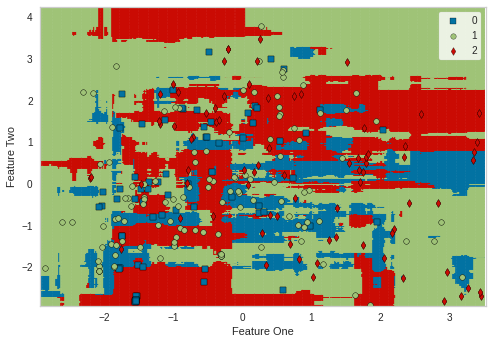

In [ ]:
plot_model(best_models[0],"boundary")

#7. Hyper parameter Tuning

## Catboost_custom

Best Model : catboost
> We got a promising AUC So we Tune the model by optimising Accuracy






In [ ]:
import decimal
def float_range(start, stop, step):
  while start < stop:
    yield float(start)
    start += float(decimal.Decimal(step))

In [ ]:
best_models[1].get_params()

{'border_count': 254,
 'random_state': 123,
 'task_type': 'CPU',
 'verbose': False}

In [ ]:
best_models[1].get_all_params()

{'auto_class_weights': 'None',
 'bagging_temperature': 1,
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': False,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'border_count': 254,
 'class_names': [0, 1, 2],
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'MultiClass',
 'feature_border_type': 'GreedyLogSum',
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.0772780030965805,
 'loss_function': 'MultiClass',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 123,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 'Cosine',


In [ ]:
tuned_catboost_custom.get_all_params()

{'add_ridge_penalty_to_loss_function': False,
 'auto_class_weights': 'None',
 'bagging_temperature': 0.05000000074505806,
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': False,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'border_count': 280,
 'class_names': [0, 1, 2],
 'classes_count': 0,
 'data_partition': 'DocParallel',
 'depth': 7,
 'devices': '-1',
 'eval_metric': 'MultiClass',
 'feature_border_type': 'GreedyLogSum',
 'fold_size_loss_normalization': False,
 'gpu_cat_features_storage': 'GpuRam',
 'gpu_ram_part': 0.95,
 'grow_policy': 'SymmetricTree',
 'iterations': 1850,
 'l2_leaf_reg': 14,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.3089999854564667,
 'loss_function': 'MultiClass',
 'max_leaves': 128,
 'min_data_in_leaf': 1,
 'min_fold_size': 100,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'observations_to_bootstrap': 'Te

In [ ]:
# for identifying th difference between the tuned and normal model

for i in best_models[1].get_all_params():
  if i in tuned_catboost_custom.get_all_params() and i in best_models[1].get_all_params():
    if tuned_catboost_custom.get_all_params()[i] != best_models[1].get_all_params()[i]:
      print(i,tuned_catboost_custom.get_all_params()[i])

iterations 1850
l2_leaf_reg 14
random_strength 4.888000011444092
depth 7
border_count 280
bagging_temperature 0.05000000074505806
learning_rate 0.3089999854564667
task_type GPU
max_leaves 128


In [ ]:
#9.364

params = {'task_type':['GPU'],
          'bagging_temperature':[i for i in float_range(0,3,.05)],
          'border_count':[i for i in range(150,350,10)],
          'depth': [i for i in range(3,10)],
          'iterations': [i for i in range(1000,2000,50)],
          'l2_leaf_reg': [i for i in range(5,20)],
          
          'learning_rate':[ i for i in float_range(.01,1,.001)],
          'random_strength':[ i for i in float_range(.5,5,.001)],
          }
tuned_catboost_custom = tune_model(best_models[1], custom_grid = params,n_iter=10,optimize='AUC',choose_better=True,tuner_verbose=True,search_algorithm='random',)




,Accuracy,AUC,Recall,Prec.,F1
0,0.7619,0.9149,0.7575,0.7642,0.7620
1,0.7778,0.9074,0.7838,0.7812,0.7784
2,0.9206,0.9890,0.9129,0.9256,0.9202
3,0.8413,0.9575,0.8138,0.8571,0.8349
4,0.8095,0.9308,0.7999,0.8169,0.8101
5,0.8254,0.9474,0.8310,0.8375,0.8277
6,0.8571,0.9708,0.8571,0.8664,0.8553
7,0.8254,0.9487,0.8248,0.8276,0.8253
8,0.9206,0.9722,0.9185,0.9216,0.9208
9,0.7903,0.9311,0.7796,0.8035,0.7915


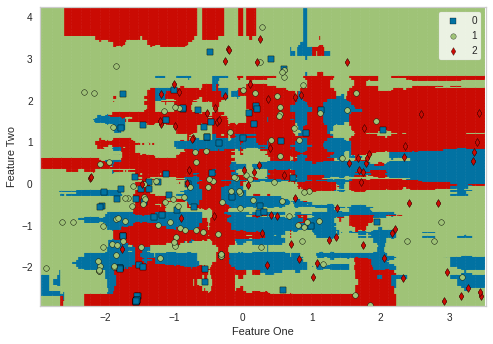

In [ ]:
plot_model(tuned_catboost_custom,"boundary")

In [ ]:
final = finalize_model(tuned_catboost_custom)

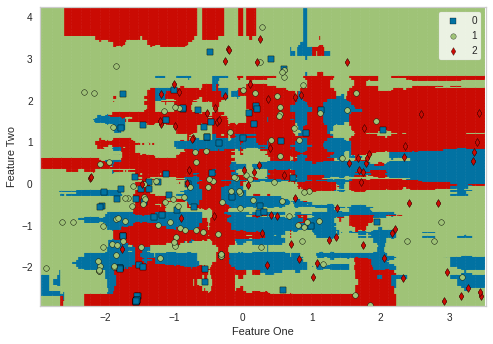

In [ ]:
plot_model(final,"boundary")

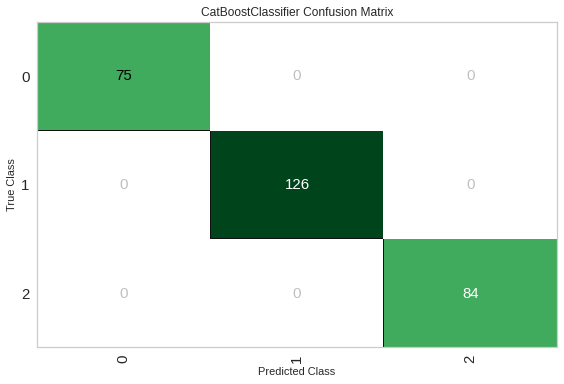

In [ ]:
plot_model(final,plot="confusion_matrix")#save=True)

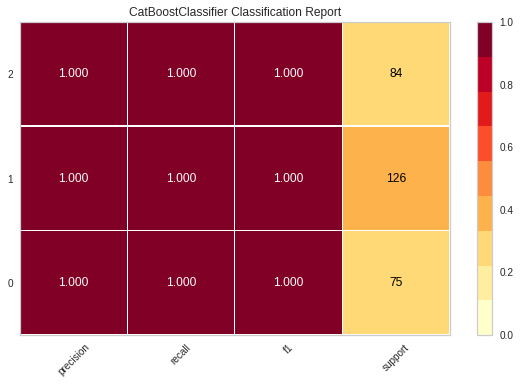

In [ ]:
plot_model(final,plot="class_report")#save=True)

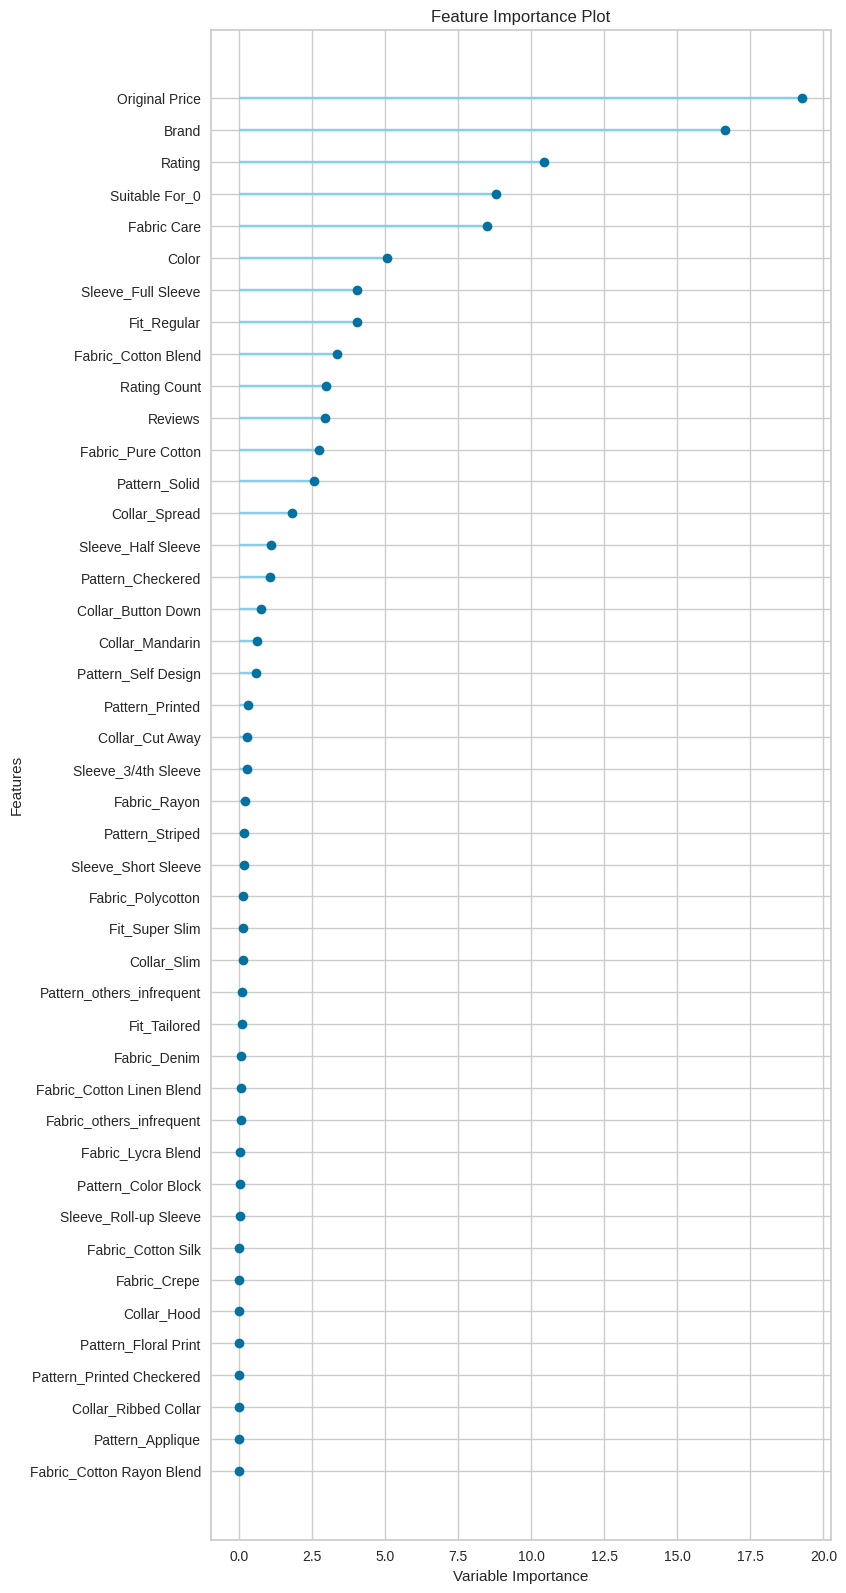

In [ ]:
plot_model(final,plot="feature_all")

>## Other tuning done

>>### rf_tuning

In [ ]:
params = {"max_depth": np.random.randint(1, (len(get_config('X_train').columns)*.85),20),
          "max_features": np.random.randint(1, len(df.columns)-1,20),
          "min_samples_leaf": [2,3,4,5,6],
          "criterion": ["gini", "entropy"],
          "n_estimators":[i for i in range(1,100,10)]}
tuned_rf_custom = tune_model(best_models[0],custom_grid=params   ,n_iter=50,optimize='AUC',choose_better=True,tuner_verbose=True,search_algorithm='random')




,Accuracy,AUC,Recall,Prec.,F1
0,0.8095,0.9217,0.8065,0.8098,0.8094
1,0.7619,0.9280,0.7653,0.7619,0.7616
2,0.8730,0.9769,0.8464,0.8904,0.8707
3,0.7778,0.9295,0.7596,0.7941,0.7741
4,0.7937,0.9134,0.7880,0.7968,0.7940
5,0.7460,0.9377,0.7334,0.7446,0.7450
6,0.8413,0.9591,0.8274,0.8478,0.8353
7,0.8254,0.9281,0.8175,0.8275,0.8237
8,0.8254,0.9438,0.8248,0.8254,0.8254
9,0.7581,0.9077,0.7600,0.7608,0.7591


In [ ]:
tuned_rf_custom

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

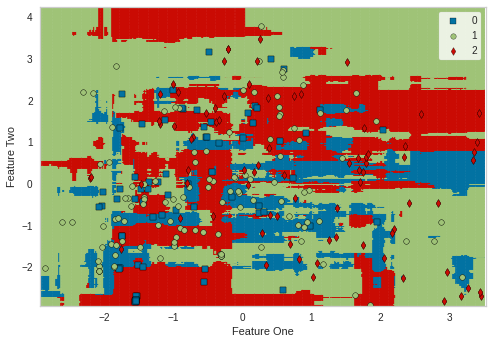

In [ ]:
plot_model(tuned_rf_custom,"boundary")

In [ ]:
final = finalize_model(tuned_rf_custom)

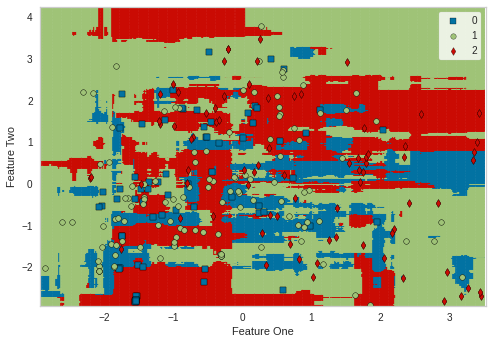

In [ ]:
plot_model(final,"boundary")

>>### xgboost_tuning

In [ ]:
# best_models[0]

In [ ]:
# import decimal
# def float_range(start, stop, step):
#   while start < stop:
#     yield float(start)
#     start += float(decimal.Decimal(step))

In [ ]:
# params={'booster':'gblinear'}

In [ ]:
# tuned_xgboost = tune_model(best_models[0], custom_grid = params,n_iter=50,optimize='AUC',choose_better=True,tuner_verbose=True,search_algorithm='random',)

In [ ]:
# params = {"min_child_weight": [i for i in range(1,len(df_seen.columns))],
#           "max_depth": [i for i in range(1,10)],
#           "colsample_bytree":[i for i in float_range(0.5,1,0.05)],
#           "n_estimators":[i for i in range(1,100,1)],


#           "gamma": [i for i in float_range(0.1,1.5,0.05)],
#           "learning_rate":[ i for i in float_range(.1,.3,.001)],
#           "subsample":[i for i in float_range(0.5,1,0.05)]}
# tuned_xgboost = tune_model(best_models[0], custom_grid = params,n_iter=50,optimize='AUC',choose_better=True,tuner_verbose=True,search_algorithm='random',)

In [ ]:
# tuned_xgboost
# 0.7351

In [ ]:
# plot_model(tuned_xgboost,"boundary")

#8. Pickling the model

This prevents the model from training again and again

In [ ]:
final

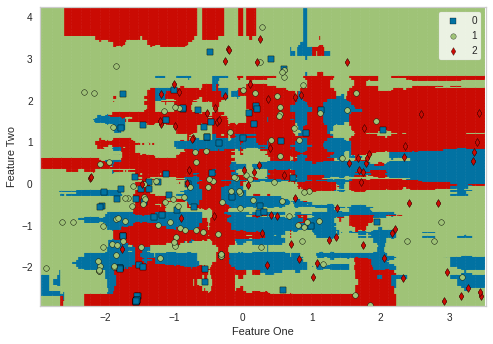

In [ ]:
plot_model(final,"boundary")

In [ ]:
save_model(final,'flpkrt_shirt_discnt_prediction')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['Original Price',
                                                           'Rating',
                                                           'Rating Count',
                                                           'Reviews'],
                                       target='Label', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='most frequent',
                                 fill_value_categoric...
                                                     subclass='multi',
                                                     target='Label',
                   

In [ ]:
new_model = load_model('flpkrt_shirt_discnt_prediction')

#9. Prediction

In [ ]:
df_seen_pre = df_unseen.drop('Label',axis=1)
unseen_df_predcit = predict_model(new_model,df_seen_pre)

In [ ]:
df_unseen['Label'] = df_unseen['Label'].astype('int64')

In [ ]:
multilabel_confusion_matrix(unseen_df_predcit['Label'],df_unseen['Label'])

array([[[4, 0],
        [0, 1]],

       [[2, 0],
        [0, 3]],

       [[4, 0],
        [0, 1]]])

In [ ]:
df_seen.columns

In [ ]:
nam =[]
for i in df_seen['Brand']:
  nam.append(i)

In [ ]:
nam